In [1]:
import torch 
import random
import os
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
from PIL import Image
import evaluate
from typing import Any

from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation
)

import albumentations as A 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import huggingface_hub 
import wandb

In [ ]:
wandb.init()

In [3]:
random.seed(1)
torch.manual_seed(1)

In [4]:
data_dir = '../data/Task01_BrainTumour/'

with open(os.path.join(data_dir, 'dataset.json'), 'r') as f:
    dataset = json.load(f)

In [5]:
all_train_files = [
    {"image": os.path.join(data_dir, d["image"]), "label": os.path.join(data_dir, d["label"])}
    for d in dataset['training']]

test_files = [{"image": os.path.join(data_dir, d)} for d in dataset['test']]


# I am going to create a validation set from a subset of train_files
random.shuffle(all_train_files)
n_files_for_validation = int(len(all_train_files) * .05)

val_files = all_train_files[-n_files_for_validation:]
train_files = all_train_files[:-n_files_for_validation]


In [6]:
def load_nii(path): 
    return nib.load(path).get_fdata()
     
def normalize_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

In [7]:
def load_flair(sample, slice_idx = None):
    return load_nii(sample["image"])[:, :, slice_idx, 0]

def load_mask_brain_edema(sample, slice_idx):
    mask_flair = load_flair(sample, slice_idx)
    mask_labels = load_nii(sample["label"])[:, :, slice_idx]

    # 0: background, 1: brain, 2: edema
    return np.where(
        mask_labels >= 1, 2, np.where(
            mask_flair >= 1, 1, 0
        )
    )

In [8]:
sample = random.choice(train_files)

In [9]:
def visualize_sample(sample: dict, slice_idx = 75, axis = None):
    img = load_flair(sample, slice_idx)
    mapping = load_mask_brain_edema(sample, slice_idx)
    mapping = np.where(mapping == 0, np.nan, mapping)

    img = normalize_img(img)
    if axis is None:
        _, ax = plt.subplots(1, 2, figsize=(12, 5)) 
    else: 
        ax = axis
    
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("MRI Image (FLAIR)")
    ax[0].axis("off")

    ax[1].imshow(img, cmap="gray")
    ax[1].imshow(mapping, cmap="spring", alpha=.4)
    ax[1].set_title("Segmentation Mask Overlay")
    ax[1].axis("off")

    if axis is None:
        plt.show()

    return ax

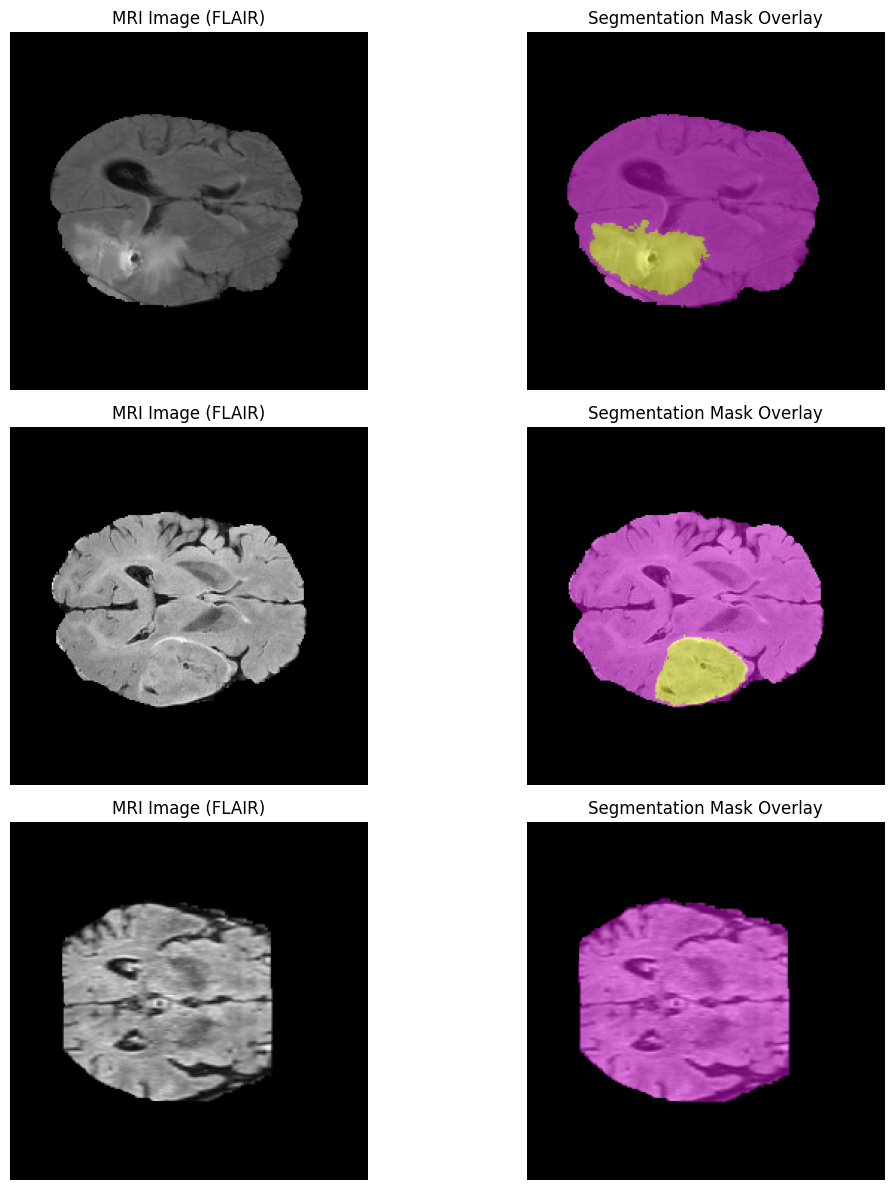

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns (MRI + Overlay)
samples = random.sample(train_files, 3)  # Pick 3 random samples

# Loop through each row and plot using the modified function
for i in range(3):
    visualize_sample(samples[i], 70, axes[i])

plt.tight_layout()
plt.show()


In [11]:
id2label = {int(k): v for k, v in dataset['labels'].items()}
id2label = {0: 'background', 1: 'brain', 2: 'edema'}
id2label

{0: 'background', 1: 'brain', 2: 'edema'}

In [12]:
relevant_slices = [75, 85, 105]

### Preparing the dataset for training

In [13]:
@dataclass
class BRATDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray


class BRATSDataset(Dataset):
    def __init__(self, data_list, transforms=None, slice_axis=2):
        """
        Args:
            data_list: List of dictionaries with {'image': path, 'label': path}.
            transforms: Albumentations transforms for data augmentation.
            slice_axis: Axis along which to extract 2D slices (0=axial, 1=coronal, 2=sagittal).
        """
        self.data_list = data_list
        self.transforms = transforms
        self.slice_axis = slice_axis
        self.slices_to_retrieve = relevant_slices
    
    def __len__(self):
        return len(self.data_list) * len(self.slices_to_retrieve)

    def __getitem__(self, idx):
        scan_idx = idx // len(self.slices_to_retrieve)
        slice_idx = self.slices_to_retrieve[idx % len(self.slices_to_retrieve)]

        sample = self.data_list[scan_idx]

        image_data = load_flair(sample, slice_idx) # (240, 240)
        image_data = normalize_img(image_data) # (240, 240)
        image_data = np.stack([image_data] * 3, axis=-1) # turns into 3 channels (240, 240, 3)
        image_data = image_data.astype(np.float32)

        label_data = load_mask_brain_edema(sample, slice_idx)

        label_data = label_data.astype(np.uint8)        

        # transformations 
        if self.transforms:
            augmented = self.transforms(image=image_data, mask=label_data)
            transformed_image = augmented["image"]
            transformed_segmentation_map = augmented["mask"]
        else:
            transformed_image, transformed_segmentation_map = image_data, label_data
        
        return BRATDataInput(
            original_image=image_data,
            original_segmentation_map=label_data,
            transformed_image=transformed_image,
            transformed_segmentation_map=transformed_segmentation_map
        )


preprocessor = MaskFormerImageProcessor(
    ignore_index=-1,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

def collate_fn(batch: BRATDataInput) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_segmentation_maps = [sample.original_segmentation_map for sample in batch]
    transformed_segmentation_maps = [
        sample.transformed_segmentation_map for sample in batch
    ]

    preprocessed_batch = preprocessor(
        transformed_images,
        segmentation_maps=transformed_segmentation_maps,
        return_tensors="pt",
    )

    preprocessed_batch["original_images"] = original_images
    preprocessed_batch["original_segmentation_maps"] = original_segmentation_maps

    return preprocessed_batch


Determines the observed means and std for normalization

In [14]:

def compute_mean_std(data_list, relevant_slices):
    """Compute mean and std for each MRI modality across the entire dataset."""
    sum_pixels = 0
    sum_sq_pixels = 0
    total_pixels = 0
    
    for sample in data_list:
        image_data = np.stack([load_flair(sample, slice_idx) for slice_idx in relevant_slices], axis=0)

        sum_pixels += image_data.sum()
        sum_sq_pixels += (image_data ** 2).sum()
        total_pixels += image_data.size

    # Compute final mean and std
    mean = sum_pixels / total_pixels
    std = np.sqrt((sum_sq_pixels / total_pixels) - (mean ** 2))  # Variance -> Std

    return np.float32(mean), np.float32(std)

# Compute on training dataset
#mean_train, std_train = compute_mean_std(train_files, relevant_slices)
mean_train = 128.21144104003906
std_train = 255.01385498046875

print(f"Computed Mean: {mean_train}, Computed Std: {std_train}")


Computed Mean: 128.21144104003906, Computed Std: 255.01385498046875


In [15]:
## data augmentation and data loader 
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=[mean_train] * 3, std=[std_train] * 3),
    A.ToTensorV2()
])

valtest_transform = A.Compose([
    A.Normalize(mean=[mean_train] * 3, std=[std_train] * 3),
    A.ToTensorV2()
])

In [16]:
train_dataset = BRATSDataset(train_files, transforms=train_transform)
val_dataset = BRATSDataset(val_files, transforms=valtest_transform)
test_dataset = BRATSDataset(test_files, transforms=valtest_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [17]:
sample_data = next(iter(train_loader))

In [18]:
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample_data.items()
    }
)

{'pixel_values': torch.Size([32, 3, 240, 240]), 'pixel_mask': torch.Size([32, 240, 240]), 'mask_labels': torch.Size([3, 240, 240]), 'class_labels': torch.Size([3]), 'original_images': (240, 240, 3), 'original_segmentation_maps': (240, 240)}


Create coco annotations

### Denormalization of the images

In [19]:
def denormalize(image_tensor):
    """Reverses normalization and restores image values correctly."""
    # Move tensor to CPU and convert to NumPy
    image_np = image_tensor.detach().cpu().numpy()

    image_np = image_np[0]  # Convert from (C, H, W) -> (H, W, C)

    # Reverse normalization
    image_np = (image_np * std_train) + mean_train

    # Ensure values are properly scaled
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-6)  # Rescale to 0-1

    # Convert to uint8 (0-255)
    image_np = (image_np * 255).astype(np.uint8)

    return image_np


Text(0.5, 1.0, 'Reconstructed image (transformed)')

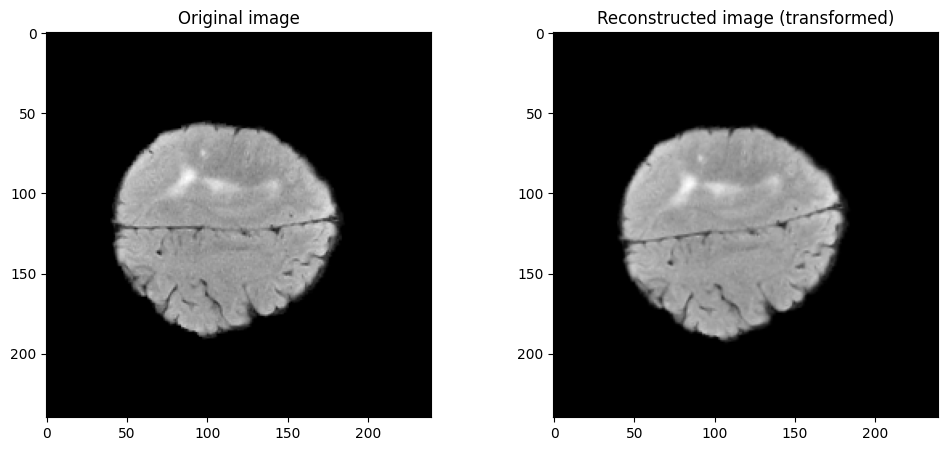

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(sample_data['original_images'][-1], cmap='gray')
ax[0].set_title('Original image')


ax[1].imshow(denormalize(sample_data['pixel_values'][-1]), cmap='gray')
ax[1].set_title('Reconstructed image (transformed)')

### Load Model

In [21]:
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco", use_fast=True)
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-coco", 
)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
/Users/alexis/Projects/202503 Brain Image Segmentation/.environment/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


#### Predicting with model out-of-the-box

In [22]:
image = denormalize(sample_data['pixel_values'])

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs
)[0]

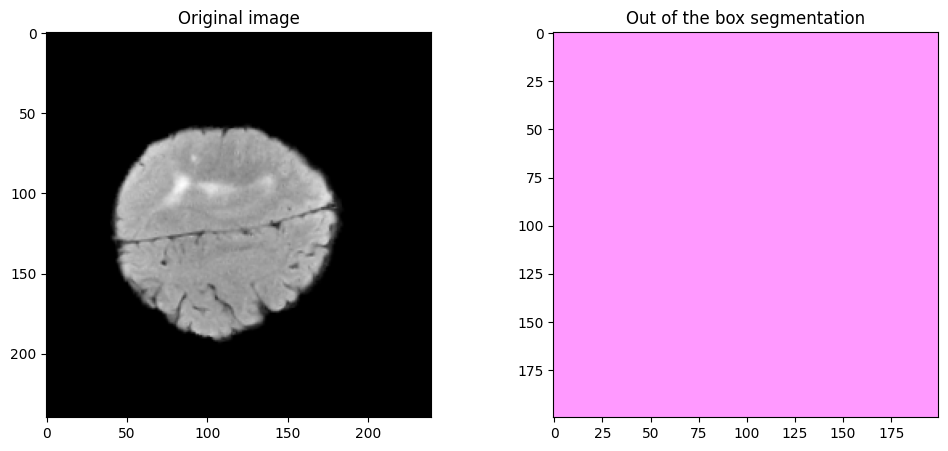

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(denormalize(sample_data['pixel_values'][-1]), cmap='gray')
ax[0].set_title('Original image')

ax[0].imshow(denormalize(sample_data['pixel_values'][-1]), cmap='gray')
ax[1].imshow(predicted_semantic_map, cmap="spring", alpha=.4)
#ax[1].imshow(predicted_semantic_map)
ax[1].set_title('Out of the box segmentation')

plt.show()

The identifies de outline of the brain image, but not the tumor

In [24]:
predicted_semantic_map = processor.post_process_panoptic_segmentation(
    outputs
)[0]
predicted_semantic_map

`label_ids_to_fuse` unset. No instance will be fused.


{'segmentation': tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 'segments_info': []}

### Training

In [25]:
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-ade", id2label=id2label, ignore_mismatched_sizes=True, num_labels=3
)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# pixel level module contains both the backbone and the pixel decoder
for param in model.model.pixel_level_module.parameters():
    param.requires_grad = False

# Confirm that the parameters are correctly frozen
for name, param in model.model.pixel_level_module.named_parameters():
    assert not param.requires_grad

In [27]:
# Freeze all parameters in pixel_level_module first
for param in model.model.pixel_level_module.parameters():
    param.requires_grad = False

# Then selectively unfreeze the pixel decoder
for param in model.model.pixel_level_module.decoder.parameters():
    param.requires_grad = True

# the last stage for a 4-stage Swin
for name, param in model.model.pixel_level_module.encoder.named_parameters():
    if "layers.3" in name:  
        param.requires_grad = True


In [28]:
for name, param in model.model.pixel_level_module.named_parameters():
    print(name, param.requires_grad)

encoder.model.embeddings.patch_embeddings.projection.weight False
encoder.model.embeddings.patch_embeddings.projection.bias False
encoder.model.embeddings.norm.weight False
encoder.model.embeddings.norm.bias False
encoder.model.encoder.layers.0.blocks.0.layernorm_before.weight False
encoder.model.encoder.layers.0.blocks.0.layernorm_before.bias False
encoder.model.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table False
encoder.model.encoder.layers.0.blocks.0.attention.self.query.weight False
encoder.model.encoder.layers.0.blocks.0.attention.self.query.bias False
encoder.model.encoder.layers.0.blocks.0.attention.self.key.weight False
encoder.model.encoder.layers.0.blocks.0.attention.self.key.bias False
encoder.model.encoder.layers.0.blocks.0.attention.self.value.weight False
encoder.model.encoder.layers.0.blocks.0.attention.self.value.bias False
encoder.model.encoder.layers.0.blocks.0.attention.output.dense.weight False
encoder.model.encoder.layers.0.blocks.0.attentio

In [29]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("device:", device)

device: mps


In [30]:
from typing import Any 

metric = evaluate.load("mean_iou")

def evaluate_model(
    model: MaskFormerForInstanceSegmentation,
    dataloder: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: Any,
    id2label: dict, 
    max_batches=None
    ):
    
    model.eval()
    
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloder)):
            if max_batches and idx >= max_batches:
                break
            
            pixel_values = batch["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            original_images = batch["original_images"]#.to(device)
            target_sizes = [
                (image.shape[0], image.shape[1]) for image in original_images
            ]

            predicted_segmentation_maps = (
                preprocessor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )
            )

            ground_truth_segmentation_maps = batch["original_segmentation_maps"]
            
            metric.add_batch(
                references=ground_truth_segmentation_maps,
                predictions=predicted_segmentation_maps
            )

    
    metric_score = metric.compute(num_labels=len(id2label), ignore_index=None)
    return metric_score
   

In [31]:
def compute_class_weights(data_list, id2label, relevant_slices):
    num_classes = len(id2label)

    pixel_counts = np.zeros(num_classes)  # Count pixels per class

    for file in data_list:
        mask = np.stack([
            load_mask_brain_edema(file, idx) for idx in relevant_slices
        ])

    for class_idx in range(num_classes):
        pixel_counts[class_idx] += np.sum(mask == class_idx)
    
    class_weights = pixel_counts.sum() / pixel_counts
    class_weights /= class_weights.sum() # normalized
    return torch.tensor(class_weights, dtype=torch.float32, device=device)

#class_weights = compute_class_weights(train_files[:1000], id2label, relevant_slices)

class_weights = torch.tensor([0.0525, 0.1694, 0.7781], dtype=torch.float32, device=device)

class_weights


tensor([0.0525, 0.1694, 0.7781], device='mps:0')

In [32]:

def pad_target_masks(target_masks, num_classes):
    """
    Efficiently pads target masks to ensure they all have `num_classes` channels.

    Args:
        target_masks (List[Tensor]): List of masks, each with variable channels.
        num_classes (int): The total number of segmentation classes.

    Returns:
        Tensor: A single tensor with shape [batch_size, num_classes, H, W].
    """
    batch_size = len(target_masks)

    # Find max height & width (all masks should have same spatial size)
    H, W = target_masks[0].shape[-2:]

    # Get the number of channels for each mask
    num_channels = torch.tensor([mask.shape[0] for mask in target_masks], device=target_masks[0].device)

    # check if padding is needed
    if torch.all(num_channels == num_classes):
        return torch.stack(target_masks)

    
    padded_masks = torch.zeros((batch_size, num_classes, H, W), device=target_masks[0].device)

    for i, mask in enumerate(target_masks):
        padded_masks[i, :mask.shape[0], :, :] = mask

    return padded_masks


In [33]:

def dice_loss(predicted_masks, target_masks, class_weights, smooth=1e-6, num_classes=3):
    """
    Computes Weighted Dice Loss while handling cases where target masks are empty.

    Args:
        predicted_masks (Tensor): Shape [batch_size, num_queries, H, W], predicted mask logits.
        target_masks (List[Tensor]): List of tensors with different shapes, some may be empty.
        class_weights (tensor): Weights per class. Should be a tensor [weight_bg, weight_brain, weight_edema].
        smooth (float): Smoothing factor to avoid division by zero.
        num_classes (int): Number of classes.

    Returns:
        Tensor: Weighted Dice loss value.
    """
    # convert logits to probabilities
    predicted_masks = torch.sigmoid(predicted_masks)

    # padding in case not all classes are present 
    target_masks = pad_target_masks(target_masks, num_classes)

    # downsample target_masks (240x240) to match prediction sizes (60x60) 
    target_masks = F.interpolate(target_masks, size=predicted_masks.shape[-2:], mode="nearest")

    # Select the most confident mask for each class
    predicted_masks = predicted_masks[:, :num_classes]  # Ensure we use only the first `num_classes` channels

    # Flatten tensors
    predicted_masks = predicted_masks.view(predicted_masks.shape[0], num_classes, -1)  # [batch, num_classes, num_pixels]
    target_masks = target_masks.view(target_masks.shape[0], num_classes, -1)  # [batch, num_classes, num_pixels]

    # Compute Dice Score for each class
    intersection = (predicted_masks * target_masks).sum(dim=2)
    union = predicted_masks.sum(dim=2) + target_masks.sum(dim=2)
    dice = (2. * intersection + smooth) / (union + smooth)

    # Convert class_weights to tensor 
    
    weighted_dice = class_weights * (1 - dice)
    return weighted_dice.mean()



In [34]:
def combined_loss(predicted_masks, target_masks, class_weights, alpha=0.25, gamma=2, smooth=1e-6, num_classes=3):
    """
    Combines Weighted Dice Loss with Focal Loss.
    """
    dice = dice_loss(predicted_masks, target_masks, class_weights, smooth)
    
    # Focal Loss (helps with small object detection)
    predicted_masks = torch.sigmoid(predicted_masks)  # Convert logits to probabilities
    target_masks = pad_target_masks(target_masks, num_classes).to(predicted_masks.device)  # Ensure shape consistency
    target_masks = F.interpolate(target_masks, size=predicted_masks.shape[-2:], mode="nearest")
    
    bce_loss = F.binary_cross_entropy(predicted_masks, target_masks, reduction="none")
    pt = torch.exp(-bce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss

    return dice + focal_loss.mean()


In [39]:
def train_model(
    model: MaskFormerForInstanceSegmentation,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: AutoImageProcessor,
    id2label: dict,
    class_weights: torch.Tensor,
    num_epochs=100,
    learning_rate=5e-5,
    weight_decay=5e-5,
    log_interval=100,
    patience = 10,
    checkpoint_dir="checkpoints"
    
):
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val_iou = 0.0
    epochs_without_improvement = 0

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # converts weights dictionary to a tensor
    #class_weights = torch.tensor([class_weights[i] for i in range(len(id2label))], device=device)

    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        for idx, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()

            mask_labels = [labels.to(device) for labels in batch["mask_labels"]]

            outputs = model(
                pixel_values = batch["pixel_values"].to(device),
                mask_labels = mask_labels,
                class_labels = [labels.to(device) for labels in batch["class_labels"]],
            )

            loss = outputs.loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
                   
            if idx % log_interval == 0 and idx > 0:
                avg_loss = running_loss / (idx + 1)
                print(f"Epoch {epoch + 1},| Iteration {idx} - Loss: {avg_loss:.6f}")

                # Log to wandb
                wandb.log({"Training Loss": avg_loss, "Epoch": epoch + 1, "Iteration": idx})


        val_mean_iou = evaluate_model(
            model,
            val_dataloader,
            preprocessor,
            metric,
            id2label,
            max_batches=6
        )    
        print(f"Validation Mean IoU: {val_mean_iou}")

        # Log to wandb
        wandb.log({"Validation Mean IoU": val_mean_iou, "Epoch": epoch + 1})

        # Early Stopping Logic
        if val_mean_iou["mean_iou"] > best_val_iou:
            best_val_iou = val_mean_iou["mean_iou"]
            epochs_without_improvement = 0

            # Save best model checkpoint locally
            best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved at: {best_model_path}")

        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s).")

            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs of no improvement.")
                break
        
    wandb.finish()

    print("Training complete.")


In [40]:
train_model(
    model,
    train_loader,
    val_loader,
    preprocessor,
    metric,
    id2label,
    num_epochs=10,
    learning_rate=1e-4,
    class_weights=class_weights,
    log_interval=10
)

Current epoch: 1/10


 25%|██▌       | 11/44 [01:22<04:09,  7.55s/it]

Epoch 1,| Iteration 10 - Loss: 1.588390


 48%|████▊     | 21/44 [02:38<02:54,  7.60s/it]

Epoch 1,| Iteration 20 - Loss: 1.410713


 70%|███████   | 31/44 [03:54<01:38,  7.57s/it]

Epoch 1,| Iteration 30 - Loss: 1.260815


 93%|█████████▎| 41/44 [05:10<00:23,  7.69s/it]

Epoch 1,| Iteration 40 - Loss: 1.148378


  0%|          | 0/3 [00:00<?, ?it/s]/Users/alexis/Projects/202503 Brain Image Segmentation/.environment/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
100%|██████████| 3/3 [00:17<00:00,  5.76s/it]


Validation Mean IoU: {'mean_iou': 0.5527787766837339, 'mean_accuracy': 0.6309978692114696, 'overall_accuracy': 0.9156073977623457, 'per_category_iou': array([0.91878896, 0.73954737, 0.        ]), 'per_category_accuracy': array([0.93087577, 0.96211783, 0.        ])}
New best model saved at: checkpoints/best_model.pth
Current epoch: 2/10


 25%|██▌       | 11/44 [01:25<04:17,  7.80s/it]

Epoch 2,| Iteration 10 - Loss: 0.777423


 48%|████▊     | 21/44 [02:42<02:58,  7.76s/it]

Epoch 2,| Iteration 20 - Loss: 0.763908


 70%|███████   | 31/44 [03:59<01:39,  7.63s/it]

Epoch 2,| Iteration 30 - Loss: 0.761322


 93%|█████████▎| 41/44 [05:15<00:22,  7.61s/it]

Epoch 2,| Iteration 40 - Loss: 0.754925


100%|██████████| 3/3 [00:16<00:00,  5.50s/it]


Validation Mean IoU: {'mean_iou': 0.5668183586176136, 'mean_accuracy': 0.625532769255281, 'overall_accuracy': 0.9291201292438271, 'per_category_iou': array([0.93769701, 0.76275807, 0.        ]), 'per_category_accuracy': array([0.96767842, 0.90891989, 0.        ])}
New best model saved at: checkpoints/best_model.pth
Current epoch: 3/10


 25%|██▌       | 11/44 [01:23<04:11,  7.61s/it]

Epoch 3,| Iteration 10 - Loss: 0.745435


 48%|████▊     | 21/44 [02:39<02:55,  7.61s/it]

Epoch 3,| Iteration 20 - Loss: 0.739028


 70%|███████   | 31/44 [03:56<01:39,  7.64s/it]

Epoch 3,| Iteration 30 - Loss: 0.737300


 93%|█████████▎| 41/44 [05:13<00:22,  7.63s/it]

Epoch 3,| Iteration 40 - Loss: 0.739237


100%|██████████| 3/3 [00:16<00:00,  5.51s/it]


Validation Mean IoU: {'mean_iou': 0.5629610512858555, 'mean_accuracy': 0.6260902170321406, 'overall_accuracy': 0.9257024016203703, 'per_category_iou': array([0.93298568, 0.75589747, 0.        ]), 'per_category_accuracy': array([0.95965743, 0.91861322, 0.        ])}
No improvement for 1 epoch(s).
Current epoch: 4/10


 25%|██▌       | 11/44 [01:24<04:12,  7.64s/it]

Epoch 4,| Iteration 10 - Loss: 0.749004


 48%|████▊     | 21/44 [02:40<02:55,  7.64s/it]

Epoch 4,| Iteration 20 - Loss: 0.742372


 70%|███████   | 31/44 [03:57<01:39,  7.64s/it]

Epoch 4,| Iteration 30 - Loss: 0.741045


 93%|█████████▎| 41/44 [05:13<00:22,  7.64s/it]

Epoch 4,| Iteration 40 - Loss: 0.738431


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


Validation Mean IoU: {'mean_iou': 0.5621330752369688, 'mean_accuracy': 0.6200800826879274, 'overall_accuracy': 0.9263230613425926, 'per_category_iou': array([0.93408084, 0.75231838, 0.        ]), 'per_category_accuracy': array([0.9703366 , 0.88990365, 0.        ])}
No improvement for 2 epoch(s).
Current epoch: 5/10


 25%|██▌       | 11/44 [01:24<04:12,  7.66s/it]

Epoch 5,| Iteration 10 - Loss: 0.732694


 48%|████▊     | 21/44 [02:40<02:55,  7.64s/it]

Epoch 5,| Iteration 20 - Loss: 0.727245


 70%|███████   | 31/44 [03:57<01:39,  7.65s/it]

Epoch 5,| Iteration 30 - Loss: 0.730531


 93%|█████████▎| 41/44 [05:13<00:22,  7.64s/it]

Epoch 5,| Iteration 40 - Loss: 0.730489


100%|██████████| 3/3 [00:16<00:00,  5.54s/it]


Validation Mean IoU: {'mean_iou': 0.559265160273906, 'mean_accuracy': 0.6150274296224963, 'overall_accuracy': 0.9250602816358025, 'per_category_iou': array([0.93265904, 0.74513645, 0.        ]), 'per_category_accuracy': array([0.97558061, 0.86950168, 0.        ])}
No improvement for 3 epoch(s).
Current epoch: 6/10


 25%|██▌       | 11/44 [01:24<04:13,  7.68s/it]

Epoch 6,| Iteration 10 - Loss: 0.734156


 48%|████▊     | 21/44 [02:40<02:55,  7.64s/it]

Epoch 6,| Iteration 20 - Loss: 0.733206


 70%|███████   | 31/44 [03:57<01:39,  7.64s/it]

Epoch 6,| Iteration 30 - Loss: 0.729473


 93%|█████████▎| 41/44 [05:13<00:22,  7.64s/it]

Epoch 6,| Iteration 40 - Loss: 0.727732


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


Validation Mean IoU: {'mean_iou': 0.5660349487743283, 'mean_accuracy': 0.6215870586230049, 'overall_accuracy': 0.9293289448302469, 'per_category_iou': array([0.93818978, 0.75991506, 0.        ]), 'per_category_accuracy': array([0.97427376, 0.89048742, 0.        ])}
No improvement for 4 epoch(s).
Current epoch: 7/10


 25%|██▌       | 11/44 [01:24<04:10,  7.60s/it]

Epoch 7,| Iteration 10 - Loss: 0.726002


 48%|████▊     | 21/44 [02:39<02:53,  7.55s/it]

Epoch 7,| Iteration 20 - Loss: 0.729579


 70%|███████   | 31/44 [03:55<01:38,  7.57s/it]

Epoch 7,| Iteration 30 - Loss: 0.725462


 93%|█████████▎| 41/44 [05:10<00:22,  7.54s/it]

Epoch 7,| Iteration 40 - Loss: 0.726610


100%|██████████| 3/3 [00:16<00:00,  5.45s/it]


Validation Mean IoU: {'mean_iou': 0.5578173546925914, 'mean_accuracy': 0.6210393836521244, 'overall_accuracy': 0.9223876350308642, 'per_category_iou': array([0.92875528, 0.74469679, 0.        ]), 'per_category_accuracy': array([0.96060521, 0.90251294, 0.        ])}
No improvement for 5 epoch(s).
Current epoch: 8/10


 25%|██▌       | 11/44 [01:24<04:21,  7.91s/it]

Epoch 8,| Iteration 10 - Loss: 0.725641


 48%|████▊     | 21/44 [02:41<02:55,  7.62s/it]

Epoch 8,| Iteration 20 - Loss: 0.722239


 70%|███████   | 31/44 [03:57<01:38,  7.60s/it]

Epoch 8,| Iteration 30 - Loss: 0.724650


 93%|█████████▎| 41/44 [05:12<00:22,  7.53s/it]

Epoch 8,| Iteration 40 - Loss: 0.723385


100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


Validation Mean IoU: {'mean_iou': 0.5630204660022061, 'mean_accuracy': 0.6179395984708002, 'overall_accuracy': 0.927606819058642, 'per_category_iou': array([0.93603319, 0.75302821, 0.        ]), 'per_category_accuracy': array([0.97636346, 0.87745533, 0.        ])}
No improvement for 6 epoch(s).
Current epoch: 9/10


 25%|██▌       | 11/44 [01:23<04:08,  7.53s/it]

Epoch 9,| Iteration 10 - Loss: 0.732126


 48%|████▊     | 21/44 [02:38<02:53,  7.54s/it]

Epoch 9,| Iteration 20 - Loss: 0.727460


 70%|███████   | 31/44 [03:54<01:38,  7.57s/it]

Epoch 9,| Iteration 30 - Loss: 0.725567


 93%|█████████▎| 41/44 [05:10<00:22,  7.61s/it]

Epoch 9,| Iteration 40 - Loss: 0.724664


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


Validation Mean IoU: {'mean_iou': 0.5564139978384434, 'mean_accuracy': 0.6105236505168388, 'overall_accuracy': 0.9237078028549383, 'per_category_iou': array([0.93105513, 0.73818686, 0.        ]), 'per_category_accuracy': array([0.97978026, 0.85179069, 0.        ])}
No improvement for 7 epoch(s).
Current epoch: 10/10


 25%|██▌       | 11/44 [01:23<04:10,  7.59s/it]

Epoch 10,| Iteration 10 - Loss: 0.724127


 48%|████▊     | 21/44 [02:39<02:54,  7.59s/it]

Epoch 10,| Iteration 20 - Loss: 0.718987


 70%|███████   | 31/44 [03:55<01:38,  7.57s/it]

Epoch 10,| Iteration 30 - Loss: 0.722620


 93%|█████████▎| 41/44 [05:10<00:22,  7.54s/it]

Epoch 10,| Iteration 40 - Loss: 0.724447


100%|██████████| 3/3 [00:16<00:00,  5.46s/it]


Validation Mean IoU: {'mean_iou': 0.5605363782874023, 'mean_accuracy': 0.6160445016225564, 'overall_accuracy': 0.9259109760802469, 'per_category_iou': array([0.93376555, 0.74784359, 0.        ]), 'per_category_accuracy': array([0.97577309, 0.87236042, 0.        ])}
No improvement for 8 epoch(s).


Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Iteration,▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█
Training Loss,█▇▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,10
Iteration,40
Training Loss,0.72445


Training complete.


In [41]:
sample_data = next(iter(val_loader))

In [42]:
image = denormalize(sample_data['pixel_values'])

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs, target_sizes=[(240, 240)]
)[0]

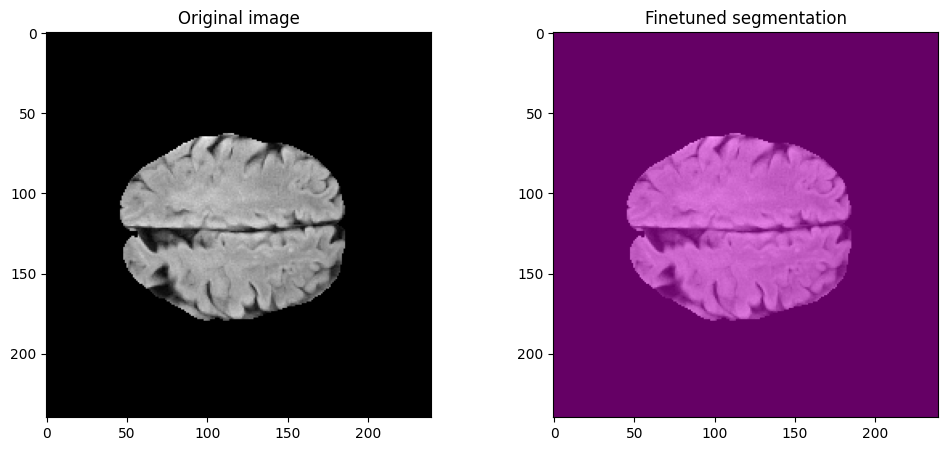

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(denormalize(sample_data['pixel_values'][-1]), cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(denormalize(sample_data['pixel_values'][-1]), cmap='gray')
ax[1].imshow(predicted_semantic_map.cpu().numpy(), cmap="spring", alpha=.4)
ax[1].set_title('Finetuned segmentation')

plt.show()